# Annotation Evaluation via Classification

Put your trained Large Language Model to use to examine how annotators and guidelines might have influenced the model performance. Specifically, you’ll perform annotator ablation tests where we hold out the annotations of some groups of annotators and see how (1) the model performance changes and (2) in the validation set, whether model predictions
are more or less similar to those annotators’ labels.

In [1]:
import os
from pathlib import Path

from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import seaborn as sns

from datasets import load_dataset, load_metric, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, EarlyStoppingCallback
from transformers import Trainer, TrainingArguments, EvalPrediction
import torch
import wandb
torch.cuda.empty_cache()

In [3]:
# define ablation metrics function
def compute_ablation_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions
    preds = preds.reshape(len(preds),)
    mse = mean_squared_error(labels, preds)
    return {
        'mse': mse
    }

## Load Data

In [4]:
train_data = pd.read_csv('data/si630w22-hw3-train.csv')
dev_data = pd.read_csv('data/si630w22-hw3-dev.csv')
q_and_a_data = pd.read_csv('data/si630w22-hw3-data.csv')

In [5]:
q_and_a_data['text'] = q_and_a_data.question_text + '[SEP]' + q_and_a_data.reply_text

In [6]:
train_data_ablation = train_data.rename(columns={'id':'question_id', 'rating':'labels'})
train_data_ablation = pd.merge(train_data_ablation,q_and_a_data[['text','question_id']], on='question_id', how='left')
train_data_ablation.dropna(subset=['labels'], inplace = True)

dev_data_ablation = dev_data.rename(columns={'id':'question_id', 'rating':'labels'})
dev_data_ablation = pd.merge(dev_data_ablation,q_and_a_data[['text','question_id']], on='question_id', how='left')
dev_data_ablation.dropna(subset=['labels'], inplace = True)

## Initialize Ablation Directories

In [7]:
# all groups
all_groups = train_data_ablation.group.unique()

# make ablation_data dirs for all groups
ablation_data_dir = Path('./ablation_data/') 
if ablation_data_dir.exists() == False:
    print("Creating Ablation Data Directory")
    os.mkdir(ablation_data_dir)
    for group_name in all_groups:
        group_dir = group_name
        group_path = os.path.join(ablation_data_dir, group_dir)
        os.mkdir(group_path)
else:
    print("Ablation Data Directory Already Exists")
    
# make ablation_training dirs for all groups
ablation_training_dir = Path('./ablation_training/') 
if ablation_training_dir.exists() == False:
    print("Creating Ablation Training Directory")
    os.mkdir(ablation_training_dir)
    for group_name in all_groups:
        group_dir = group_name
        group_path = os.path.join(ablation_training_dir, group_dir)
        os.mkdir(group_path)
else:
    print("Ablation Training Directory Already Exists")

# make ablation_model_save dirs for all groups
ablation_model_dir = Path('./ablation_model/') 
if ablation_model_dir.exists() == False:
    print("Creating Ablation Saved Model Directory")
    os.mkdir(ablation_model_dir)
    for group_name in all_groups:
        group_dir = group_name
        group_path = os.path.join(ablation_model_dir, group_dir)
        os.mkdir(group_path)
else:
    print("Ablation Saved Model Directory Already Exists")

# make ablation_prediction dirs for all groups
ablation_predict_dir = Path('./ablation_prediction/') 
if ablation_predict_dir.exists() == False:
    print("Creating Ablation Prediction Directory")
    os.mkdir(ablation_predict_dir)
    for group_name in all_groups:
        group_dir = group_name
        group_path = os.path.join(ablation_predict_dir, group_dir)
        os.mkdir(group_path)
else:
    print("Ablation Prediction Directory Already Exists")

Ablation Data Directory Already Exists
Ablation Training Directory Already Exists
Ablation Saved Model Directory Already Exists
Ablation Prediction Directory Already Exists


## Initial Debugging Pass

Complete Ablation Test Method only on Group 1. Then generalize code to loop through all groups to perform ablation tests.

After initial debugging pass was completed without error on `group_01`, the code was copied into a loop and tested on the first three groups in `all_groups`. Then, once this ran without error, the loop was applied to every group in `all_groups`.

The method is outlined below, but debugging code was removed.
1. Create Group Specific Paths
2. Create Train Data
3. Create Test Data
    - Training
        1. remove any question_ids annotated by group 1. This is the first training set
        2. group by remaining question_ids (after group 1 ids were removed) and average the rating value - this is the ground truth for training
        3. apply the rating value to the question_ids in the training set
    - Dev Split A
        1. repeat the process used for the training set ground truth labels
    - Dev Split B
        1. using only group 1 question_ids, average the rating value of group 1 annotators on these question_ids - this is the ground truth for dev split b
        2. apply the rating value to the question_ids in the dev split b set
    - Dev Split C
        1. using only group 1 question_ids, average the rating value of all other groups (excluding group 1) on these question_ids - this is the ground truth for dev split c
        2. apply the rating value to the question_ids in the dev split c set
    - Repeat this process for every single group
        - There will be 3 separate ground truth labels for each of the Dev splits. We then evaluate each dev split (for every group) and calcualate correlation for every group and plot.
4. Data Preprocessing
    - Data Loading
    - Data Tokenizing
    - Data Formatting
5. Intialize and Train Model
6. Make Predictions
7. Calculate Correlations

## Complete Ablation Tests

Loop through all groups (23 in total) and complete the ablation test method

In [8]:
# same tokenizer for every group
tokenizer = BertTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased", padding = True, truncation=True ,max_length =512)

# same model and training args for every training.
helpfulness_model = BertForSequenceClassification.from_pretrained("simple_best_model/", num_labels=1)

In [9]:
all_correlations = []
for group_name in all_groups:
    
    # create group specific paths
    group_data_path = os.path.join(ablation_data_dir, group_name)
    group_training_path = os.path.join(ablation_training_dir, group_name)
    group_model_path = os.path.join(ablation_model_dir, group_name)
    group_predict_path = os.path.join(ablation_predict_dir, group_name)

    print('STARTING ABLATION:', group_name.upper())
    
    # remove all annotations by any annotator in g1 from training data
    print('CREATING TRAIN DATA')

    g_annotators = train_data_ablation[train_data_ablation['group'] == group_name].annotator_id.unique()
    g_drop_index = train_data_ablation[train_data_ablation['annotator_id'].isin(g_annotators)].index
    g_drop_data = train_data_ablation.drop(g_drop_index)

    # create ground truth by averaging scores of remaining annotators
    g_truth = g_drop_data.groupby('question_id').mean()
    g_drop_data_truth = g_drop_data.merge(g_truth, on='question_id', how='left').drop(columns='labels_x').rename(columns={'labels_y':'labels'}).drop_duplicates(subset='question_id')
    g_drop_data_truth.to_csv(os.path.join(group_data_path, group_name+'_train.csv'), index=False)
    
    # split dev data into 3 test sets 
    print('CREATING TEST DATA')
    g_qdev_index = dev_data_ablation[dev_data_ablation['annotator_id'].isin(g_annotators)].index

    # replies without any annotators in g
    g_dev_a = dev_data_ablation.drop(g_qdev_index)
    g_truth_a = g_dev_a.groupby('question_id').mean()
    g_dev_a_truth = g_dev_a.merge(g_truth_a, on='question_id', how='left').drop(columns='labels_x').rename(columns={'labels_y':'labels'}).drop_duplicates(subset='question_id')
    g_dev_a_truth.to_csv(os.path.join(group_data_path, group_name+'_dev_a.csv'), index=False)

    # replies to items with annotators in g1 and using their annotations
    g_dev_b = dev_data_ablation.loc[g_qdev_index]
    g_truth_b = g_dev_b.groupby('question_id').mean()
    g_dev_b_truth = g_dev_b.merge(g_truth_b, on='question_id', how='left').drop(columns='labels_x').rename(columns={'labels_y':'labels'}).drop_duplicates(subset='question_id')
    g_dev_b_truth.to_csv(os.path.join(group_data_path, group_name+'_dev_b.csv'), index=False)

    # the same replies as b but using the annotations by the individuals not in g1
    g_qids = g_dev_b.question_id.unique()
    g_dev_c = g_dev_a[g_dev_a['question_id'].isin(g_qids)].copy()
    g_truth_c = g_dev_c.groupby('question_id').mean()
    g_dev_c_truth = g_dev_c.merge(g_truth_c, on='question_id', how='left').drop(columns='labels_x').rename(columns={'labels_y':'labels'}).drop_duplicates(subset='question_id')
    g_dev_c_truth.to_csv(os.path.join(group_data_path, group_name+'_dev_c.csv'), index=False)
    
    # data preprocessing - data loading
    print('LOADING DATA')
    ablation_train_dataset = load_dataset("csv", data_files={"train": os.path.join(group_data_path, group_name+'_train.csv')})
    ablation_test_dataset_a = load_dataset('csv', data_files={"test": os.path.join(group_data_path, group_name+'_dev_a.csv')})
    ablation_test_dataset_b = load_dataset('csv', data_files={"test": os.path.join(group_data_path, group_name+'_dev_b.csv')})
    ablation_test_dataset_c = load_dataset('csv', data_files={"test": os.path.join(group_data_path, group_name+'_dev_c.csv')})
    
    # data preprocessing - tokenization
    print('TOKENIZING DATA')
    tokenized_ablation_train_dataset = ablation_train_dataset['train'].map(lambda x: tokenizer(x['text'],padding = 'max_length', max_length =512, truncation=True))
    tokenized_ablation_test_dataset_a = ablation_test_dataset_a['test'].map(lambda x: tokenizer(x['text'],padding = 'max_length', max_length =512, truncation=True))
    tokenized_ablation_test_dataset_b = ablation_test_dataset_b['test'].map(lambda x: tokenizer(x['text'],padding = 'max_length', max_length =512, truncation=True))
    tokenized_ablation_test_dataset_c = ablation_test_dataset_c['test'].map(lambda x: tokenizer(x['text'],padding = 'max_length', max_length =512, truncation=True))
    
    # data preprocessing - formatting
    print('FORMATTING DATA')

    tokenized_ablation_train_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask','labels'])
    tokenized_ablation_test_dataset_a.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask','labels'])
    tokenized_ablation_test_dataset_b.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask','labels'])
    tokenized_ablation_test_dataset_c.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask','labels'])
    
    # initialize TrainingArguments, Trainer classes, model (simple_best_model) defined globally
    print('INITIALIZING MODEL')

    group_output_dir = os.path.join(group_training_path, group_name+'_model/')
    
    ablation_training_args = TrainingArguments(
        output_dir = group_output_dir, 
        num_train_epochs = 3,
        eval_steps = 500,
        learning_rate=1e-4,
        per_device_train_batch_size = 8,
        per_device_eval_batch_size = 8,
        seed = 0,
    )
    
    ablation_trainer = Trainer(
        helpfulness_model,
        ablation_training_args,
        train_dataset=tokenized_ablation_train_dataset,
        compute_metrics=compute_ablation_metrics,
    )
    
    # train the model on the ablation group
    print('TRAINING MODEL')
    ablation_trainer.train()
    ablation_trainer.save_model(os.path.join(group_model_path, group_name+'_trained_model'))
    
    # use 3 dev sets as test sets and evaluate them all separately
    print('MAKING PREDICTIONS')

    outputs_a = ablation_trainer.predict(tokenized_ablation_test_dataset_a)
    y_pred_a = outputs_a.predictions
    g_dev_a_truth['predicted'] = y_pred_a
    g_dev_a_truth['ablation_group'] = group_name
    g_dev_a_truth['subset'] = 'a'
    g_dev_a_truth['mse'] = mean_squared_error(g_dev_a_truth.labels, g_dev_a_truth.predicted)

    outputs_b = ablation_trainer.predict(tokenized_ablation_test_dataset_b)
    y_pred_b = outputs_b.predictions
    g_dev_b_truth['predicted'] = y_pred_b
    g_dev_b_truth['ablation_group'] = group_name
    g_dev_b_truth['subset'] = 'b'
    g_dev_b_truth['mse'] = mean_squared_error(g_dev_b_truth.labels, g_dev_b_truth.predicted)

    outputs_c = ablation_trainer.predict(tokenized_ablation_test_dataset_c)
    y_pred_c = outputs_c.predictions
    g_dev_c_truth['predicted'] = y_pred_c
    g_dev_c_truth['ablation_group'] = group_name
    g_dev_c_truth['subset'] = 'c'
    g_dev_c_truth['mse'] = mean_squared_error(g_dev_c_truth.labels, g_dev_c_truth.predicted)
    
    # combine predictions
    group_predictions = pd.concat([g_dev_a_truth, g_dev_b_truth, g_dev_c_truth], axis=0)
    group_predictions.to_csv(os.path.join(group_predict_path, group_name+'_predictions_combined.csv'), index=False)
    
    # calculate correlation
    group_correlations = group_predictions.drop(['question_id','annotator_id', 'group', 'mse'], axis=1).groupby(['ablation_group', 'subset']).corr()
    group_correlations_long = group_correlations.drop('labels', axis=1).reset_index().drop('level_2', axis=1).drop_duplicates(subset='subset').rename(columns={'predicted':'correlation'})
    all_correlations.append(group_correlations_long)

STARTING ABLATION: GROUP_09
CREATING TRAIN DATA
CREATING TEST DATA


Using custom data configuration default-ddfecf5ef255f014


LOADING DATA


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-ddfecf5ef255f014/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-a7c4a2c1674b1d59


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-a7c4a2c1674b1d59/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-16f259c880b4aa02


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-16f259c880b4aa02/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-983c4d24d387a4a9


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-983c4d24d387a4a9/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3768 [00:00<?, ?ex/s]

  0%|          | 0/809 [00:00<?, ?ex/s]

  0%|          | 0/61 [00:00<?, ?ex/s]

  0%|          | 0/59 [00:00<?, ?ex/s]

FORMATTING DATA
INITIALIZING MODEL


The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3768
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1413
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


TRAINING MODEL


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s-ryanlee (use `wandb login --relogin` to force relogin)


Step,Training Loss
500,0.522300
1000,0.471300


Saving model checkpoint to ablation_training/group_09/group_09_model/checkpoint-500
Configuration saved in ablation_training/group_09/group_09_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_09/group_09_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_09/group_09_model/checkpoint-1000
Configuration saved in ablation_training/group_09/group_09_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_09/group_09_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_09/group_09_trained_model
Configuration saved in ablation_model/group_09/group_09_trained_model/config.json
Model weights saved in ablation_model/group_09/group_09_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 61
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 59
  Batch size = 8


STARTING ABLATION: GROUP_03
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-0d4094ac97dea51f


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-0d4094ac97dea51f/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-5e8019c82eec7f6c


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-5e8019c82eec7f6c/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-e7b4a4ba08f68e76


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-e7b4a4ba08f68e76/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-3b82119a2cd09e4a


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-3b82119a2cd09e4a/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3766 [00:00<?, ?ex/s]

  0%|          | 0/807 [00:00<?, ?ex/s]

  0%|          | 0/62 [00:00<?, ?ex/s]

  0%|          | 0/58 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3766
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.542100
1000,0.451800


Saving model checkpoint to ablation_training/group_03/group_03_model/checkpoint-500
Configuration saved in ablation_training/group_03/group_03_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_03/group_03_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_03/group_03_model/checkpoint-1000
Configuration saved in ablation_training/group_03/group_03_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_03/group_03_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_03/group_03_trained_model
Configuration saved in ablation_model/group_03/group_03_trained_model/config.json
Model weights saved in ablation_model/group_03/group_03_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 62
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 58
  Batch size = 8


STARTING ABLATION: GROUP_10
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-df10f303a4fff7eb


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-df10f303a4fff7eb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-0f787b3aa206c9da


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-0f787b3aa206c9da/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-531ebc08d0cc5a56


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-531ebc08d0cc5a56/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-aab0270425ca1843


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-aab0270425ca1843/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3764 [00:00<?, ?ex/s]

  0%|          | 0/810 [00:00<?, ?ex/s]

  0%|          | 0/53 [00:00<?, ?ex/s]

  0%|          | 0/52 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3764
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.545500
1000,0.426200


Saving model checkpoint to ablation_training/group_10/group_10_model/checkpoint-500
Configuration saved in ablation_training/group_10/group_10_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_10/group_10_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_10/group_10_model/checkpoint-1000
Configuration saved in ablation_training/group_10/group_10_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_10/group_10_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_10/group_10_trained_model
Configuration saved in ablation_model/group_10/group_10_trained_model/config.json
Model weights saved in ablation_model/group_10/group_10_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 53
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 52
  Batch size = 8


STARTING ABLATION: GROUP_13
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-3f77bad9afce1b55


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-3f77bad9afce1b55/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-a35c3787a259d6e6


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-a35c3787a259d6e6/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-7a7bf42e58f43cc6


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-7a7bf42e58f43cc6/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-b60d563f72ee0731


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-b60d563f72ee0731/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3767 [00:00<?, ?ex/s]

  0%|          | 0/810 [00:00<?, ?ex/s]

  0%|          | 0/63 [00:00<?, ?ex/s]

  0%|          | 0/62 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3767
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.375100
1000,0.294800


Saving model checkpoint to ablation_training/group_13/group_13_model/checkpoint-500
Configuration saved in ablation_training/group_13/group_13_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_13/group_13_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_13/group_13_model/checkpoint-1000
Configuration saved in ablation_training/group_13/group_13_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_13/group_13_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_13/group_13_trained_model
Configuration saved in ablation_model/group_13/group_13_trained_model/config.json
Model weights saved in ablation_model/group_13/group_13_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 63
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 62
  Batch size = 8


STARTING ABLATION: GROUP_22
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-6d39e9e30fa383c5


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-6d39e9e30fa383c5/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-5c0067b1f0919ed0


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-5c0067b1f0919ed0/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-8414a8b51be2c6d5


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-8414a8b51be2c6d5/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-c8db4d868a623683


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-c8db4d868a623683/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3767 [00:00<?, ?ex/s]

  0%|          | 0/807 [00:00<?, ?ex/s]

  0%|          | 0/52 [00:00<?, ?ex/s]

  0%|          | 0/48 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3767
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.288100
1000,0.227800


Saving model checkpoint to ablation_training/group_22/group_22_model/checkpoint-500
Configuration saved in ablation_training/group_22/group_22_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_22/group_22_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_22/group_22_model/checkpoint-1000
Configuration saved in ablation_training/group_22/group_22_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_22/group_22_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_22/group_22_trained_model
Configuration saved in ablation_model/group_22/group_22_trained_model/config.json
Model weights saved in ablation_model/group_22/group_22_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 52
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 48
  Batch size = 8


STARTING ABLATION: GROUP_01
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-508fdc3fde522588


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-508fdc3fde522588/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-dacb1b0ea364f73d


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-dacb1b0ea364f73d/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-75c6387ec39e7fd8


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-75c6387ec39e7fd8/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-1a79d703f58f1dc0


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-1a79d703f58f1dc0/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3768 [00:00<?, ?ex/s]

  0%|          | 0/809 [00:00<?, ?ex/s]

  0%|          | 0/77 [00:00<?, ?ex/s]

  0%|          | 0/75 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3768
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.228400
1000,0.193200


Saving model checkpoint to ablation_training/group_01/group_01_model/checkpoint-500
Configuration saved in ablation_training/group_01/group_01_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_01/group_01_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_01/group_01_model/checkpoint-1000
Configuration saved in ablation_training/group_01/group_01_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_01/group_01_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_01/group_01_trained_model
Configuration saved in ablation_model/group_01/group_01_trained_model/config.json
Model weights saved in ablation_model/group_01/group_01_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 77
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 75
  Batch size = 8


STARTING ABLATION: GROUP_02
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-cc85c1513c20e6db


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-cc85c1513c20e6db/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-3b6f5d9b4dc152f5


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-3b6f5d9b4dc152f5/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-9d61516a7d932185


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-9d61516a7d932185/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-624907eadfce1322


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-624907eadfce1322/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3767 [00:00<?, ?ex/s]

  0%|          | 0/806 [00:00<?, ?ex/s]

  0%|          | 0/64 [00:00<?, ?ex/s]

  0%|          | 0/59 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3767
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.181100
1000,0.149000


Saving model checkpoint to ablation_training/group_02/group_02_model/checkpoint-500
Configuration saved in ablation_training/group_02/group_02_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_02/group_02_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_02/group_02_model/checkpoint-1000
Configuration saved in ablation_training/group_02/group_02_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_02/group_02_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_02/group_02_trained_model
Configuration saved in ablation_model/group_02/group_02_trained_model/config.json
Model weights saved in ablation_model/group_02/group_02_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 64
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 59
  Batch size = 8


STARTING ABLATION: GROUP_20
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-aa9154a7d3a48547


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-aa9154a7d3a48547/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-f9530fc87206f3ad


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-f9530fc87206f3ad/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-1b3f4c15c09efa9c


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-1b3f4c15c09efa9c/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-e8720c8d0bbdae5f


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-e8720c8d0bbdae5f/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3770 [00:00<?, ?ex/s]

  0%|          | 0/806 [00:00<?, ?ex/s]

  0%|          | 0/64 [00:00<?, ?ex/s]

  0%|          | 0/59 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3770
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.172300
1000,0.127800


Saving model checkpoint to ablation_training/group_20/group_20_model/checkpoint-500
Configuration saved in ablation_training/group_20/group_20_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_20/group_20_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_20/group_20_model/checkpoint-1000
Configuration saved in ablation_training/group_20/group_20_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_20/group_20_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_20/group_20_trained_model
Configuration saved in ablation_model/group_20/group_20_trained_model/config.json
Model weights saved in ablation_model/group_20/group_20_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 64
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 59
  Batch size = 8


STARTING ABLATION: GROUP_04
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-3d62ee07d1596f7e


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-3d62ee07d1596f7e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-fbee8b289a19375b


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-fbee8b289a19375b/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-8510393b731c693d


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-8510393b731c693d/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-7d18cdb31771ea8b


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-7d18cdb31771ea8b/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3769 [00:00<?, ?ex/s]

  0%|          | 0/809 [00:00<?, ?ex/s]

  0%|          | 0/58 [00:00<?, ?ex/s]

  0%|          | 0/56 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3769
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.139200
1000,0.102400


Saving model checkpoint to ablation_training/group_04/group_04_model/checkpoint-500
Configuration saved in ablation_training/group_04/group_04_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_04/group_04_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_04/group_04_model/checkpoint-1000
Configuration saved in ablation_training/group_04/group_04_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_04/group_04_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_04/group_04_trained_model
Configuration saved in ablation_model/group_04/group_04_trained_model/config.json
Model weights saved in ablation_model/group_04/group_04_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 58
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 56
  Batch size = 8


STARTING ABLATION: GROUP_12
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-ebbc128ce242ad4d


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-ebbc128ce242ad4d/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-dc01edaad511743e


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-dc01edaad511743e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-b711bb077cdd1cbf


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-b711bb077cdd1cbf/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-5386dbfd156170b7


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-5386dbfd156170b7/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3768 [00:00<?, ?ex/s]

  0%|          | 0/807 [00:00<?, ?ex/s]

  0%|          | 0/71 [00:00<?, ?ex/s]

  0%|          | 0/67 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3768
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.115700
1000,0.103000


Saving model checkpoint to ablation_training/group_12/group_12_model/checkpoint-500
Configuration saved in ablation_training/group_12/group_12_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_12/group_12_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_12/group_12_model/checkpoint-1000
Configuration saved in ablation_training/group_12/group_12_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_12/group_12_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_12/group_12_trained_model
Configuration saved in ablation_model/group_12/group_12_trained_model/config.json
Model weights saved in ablation_model/group_12/group_12_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 71
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 67
  Batch size = 8


STARTING ABLATION: GROUP_15
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-391017bfcbb380e2


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-391017bfcbb380e2/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-bd25b4c092fc8ddd


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-bd25b4c092fc8ddd/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-b2daf1d6ea686820


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-b2daf1d6ea686820/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-0abf72a038de83b1


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-0abf72a038de83b1/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3766 [00:00<?, ?ex/s]

  0%|          | 0/808 [00:00<?, ?ex/s]

  0%|          | 0/63 [00:00<?, ?ex/s]

  0%|          | 0/60 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3766
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.099100
1000,0.086100


Saving model checkpoint to ablation_training/group_15/group_15_model/checkpoint-500
Configuration saved in ablation_training/group_15/group_15_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_15/group_15_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_15/group_15_model/checkpoint-1000
Configuration saved in ablation_training/group_15/group_15_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_15/group_15_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_15/group_15_trained_model
Configuration saved in ablation_model/group_15/group_15_trained_model/config.json
Model weights saved in ablation_model/group_15/group_15_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 63
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 60
  Batch size = 8


STARTING ABLATION: GROUP_24
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-e70418c0813bd7ab


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-e70418c0813bd7ab/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-92de1afc62b41d62


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-92de1afc62b41d62/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-9e8f1604210bff91


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-9e8f1604210bff91/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-98bec5e45aafd497


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-98bec5e45aafd497/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3770 [00:00<?, ?ex/s]

  0%|          | 0/808 [00:00<?, ?ex/s]

  0%|          | 0/68 [00:00<?, ?ex/s]

  0%|          | 0/65 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3770
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.115800
1000,0.080700


Saving model checkpoint to ablation_training/group_24/group_24_model/checkpoint-500
Configuration saved in ablation_training/group_24/group_24_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_24/group_24_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_24/group_24_model/checkpoint-1000
Configuration saved in ablation_training/group_24/group_24_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_24/group_24_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_24/group_24_trained_model
Configuration saved in ablation_model/group_24/group_24_trained_model/config.json
Model weights saved in ablation_model/group_24/group_24_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 68
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 65
  Batch size = 8


STARTING ABLATION: GROUP_17
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-4c49026a72c5347f


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-4c49026a72c5347f/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-9a6b16c718b1367f


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-9a6b16c718b1367f/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-3412a8fdfa724380


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-3412a8fdfa724380/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-1554cee640605cf6


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-1554cee640605cf6/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3765 [00:00<?, ?ex/s]

  0%|          | 0/809 [00:00<?, ?ex/s]

  0%|          | 0/63 [00:00<?, ?ex/s]

  0%|          | 0/61 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3765
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.096000
1000,0.078800


Saving model checkpoint to ablation_training/group_17/group_17_model/checkpoint-500
Configuration saved in ablation_training/group_17/group_17_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_17/group_17_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_17/group_17_model/checkpoint-1000
Configuration saved in ablation_training/group_17/group_17_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_17/group_17_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_17/group_17_trained_model
Configuration saved in ablation_model/group_17/group_17_trained_model/config.json
Model weights saved in ablation_model/group_17/group_17_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 63
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 61
  Batch size = 8


STARTING ABLATION: GROUP_25
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-c4c636e31ea00d1a


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-c4c636e31ea00d1a/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-14ff716d49904286


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-14ff716d49904286/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-60e6f03f19f6c327


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-60e6f03f19f6c327/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-631d8185b634e338


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-631d8185b634e338/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3766 [00:00<?, ?ex/s]

  0%|          | 0/807 [00:00<?, ?ex/s]

  0%|          | 0/65 [00:00<?, ?ex/s]

  0%|          | 0/61 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3766
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.094100
1000,0.068600


Saving model checkpoint to ablation_training/group_25/group_25_model/checkpoint-500
Configuration saved in ablation_training/group_25/group_25_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_25/group_25_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_25/group_25_model/checkpoint-1000
Configuration saved in ablation_training/group_25/group_25_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_25/group_25_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_25/group_25_trained_model
Configuration saved in ablation_model/group_25/group_25_trained_model/config.json
Model weights saved in ablation_model/group_25/group_25_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 65
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 61
  Batch size = 8


STARTING ABLATION: GROUP_19
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-62c3e4eef0303be2


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-62c3e4eef0303be2/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-b6b923410325733f


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-b6b923410325733f/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-3d8bdac4390d5abc


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-3d8bdac4390d5abc/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-11a3967209dcfb2c


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-11a3967209dcfb2c/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3763 [00:00<?, ?ex/s]

  0%|          | 0/811 [00:00<?, ?ex/s]

  0%|          | 0/65 [00:00<?, ?ex/s]

  0%|          | 0/65 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3763
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.072000
1000,0.058000


Saving model checkpoint to ablation_training/group_19/group_19_model/checkpoint-500
Configuration saved in ablation_training/group_19/group_19_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_19/group_19_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_19/group_19_model/checkpoint-1000
Configuration saved in ablation_training/group_19/group_19_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_19/group_19_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_19/group_19_trained_model
Configuration saved in ablation_model/group_19/group_19_trained_model/config.json
Model weights saved in ablation_model/group_19/group_19_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 65
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 65
  Batch size = 8


STARTING ABLATION: GROUP_08
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-9f1e0a346cdb10cd


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-9f1e0a346cdb10cd/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-d9d9eccae9f3d94d


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-d9d9eccae9f3d94d/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-d4b720b4193ec480


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-d4b720b4193ec480/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-a2cf26a3d23097dc


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-a2cf26a3d23097dc/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3768 [00:00<?, ?ex/s]

  0%|          | 0/808 [00:00<?, ?ex/s]

  0%|          | 0/67 [00:00<?, ?ex/s]

  0%|          | 0/64 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3768
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.093900
1000,0.069200


Saving model checkpoint to ablation_training/group_08/group_08_model/checkpoint-500
Configuration saved in ablation_training/group_08/group_08_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_08/group_08_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_08/group_08_model/checkpoint-1000
Configuration saved in ablation_training/group_08/group_08_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_08/group_08_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_08/group_08_trained_model
Configuration saved in ablation_model/group_08/group_08_trained_model/config.json
Model weights saved in ablation_model/group_08/group_08_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 67
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 64
  Batch size = 8


STARTING ABLATION: GROUP_07
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-fd707f370fae0d1b


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-fd707f370fae0d1b/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-fe98eb276c9a8967


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-fe98eb276c9a8967/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-34eff0cbc7526169


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-34eff0cbc7526169/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-5e4bc15606c2fe42


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-5e4bc15606c2fe42/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3766 [00:00<?, ?ex/s]

  0%|          | 0/809 [00:00<?, ?ex/s]

  0%|          | 0/66 [00:00<?, ?ex/s]

  0%|          | 0/64 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3766
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.093500
1000,0.060100


Saving model checkpoint to ablation_training/group_07/group_07_model/checkpoint-500
Configuration saved in ablation_training/group_07/group_07_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_07/group_07_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_07/group_07_model/checkpoint-1000
Configuration saved in ablation_training/group_07/group_07_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_07/group_07_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_07/group_07_trained_model
Configuration saved in ablation_model/group_07/group_07_trained_model/config.json
Model weights saved in ablation_model/group_07/group_07_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 66
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 64
  Batch size = 8


STARTING ABLATION: GROUP_18
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-7ecae0978c7722b1


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-7ecae0978c7722b1/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-42b595006b964abd


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-42b595006b964abd/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-c3deda72401639d4


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-c3deda72401639d4/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-be8b3c85b55329e2


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-be8b3c85b55329e2/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3768 [00:00<?, ?ex/s]

  0%|          | 0/809 [00:00<?, ?ex/s]

  0%|          | 0/69 [00:00<?, ?ex/s]

  0%|          | 0/67 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3768
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.081300
1000,0.057500


Saving model checkpoint to ablation_training/group_18/group_18_model/checkpoint-500
Configuration saved in ablation_training/group_18/group_18_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_18/group_18_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_18/group_18_model/checkpoint-1000
Configuration saved in ablation_training/group_18/group_18_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_18/group_18_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_18/group_18_trained_model
Configuration saved in ablation_model/group_18/group_18_trained_model/config.json
Model weights saved in ablation_model/group_18/group_18_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 69
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 67
  Batch size = 8


STARTING ABLATION: GROUP_21
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-0f870535b4d9f572


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-0f870535b4d9f572/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-96f8d0c74f720ace


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-96f8d0c74f720ace/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-9d72d91ed9240be1


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-9d72d91ed9240be1/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-9b3f1e356fbce2cd


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-9b3f1e356fbce2cd/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3766 [00:00<?, ?ex/s]

  0%|          | 0/807 [00:00<?, ?ex/s]

  0%|          | 0/59 [00:00<?, ?ex/s]

  0%|          | 0/55 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3766
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.060800
1000,0.042000


Saving model checkpoint to ablation_training/group_21/group_21_model/checkpoint-500
Configuration saved in ablation_training/group_21/group_21_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_21/group_21_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_21/group_21_model/checkpoint-1000
Configuration saved in ablation_training/group_21/group_21_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_21/group_21_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_21/group_21_trained_model
Configuration saved in ablation_model/group_21/group_21_trained_model/config.json
Model weights saved in ablation_model/group_21/group_21_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 59
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


STARTING ABLATION: GROUP_16
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-50e46ffd754ec98b


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-50e46ffd754ec98b/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-18155d8bfd9d1ad4


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-18155d8bfd9d1ad4/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-e73b70f1cde583c6


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-e73b70f1cde583c6/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-f7b0c8f7cf30744f


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-f7b0c8f7cf30744f/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3766 [00:00<?, ?ex/s]

  0%|          | 0/807 [00:00<?, ?ex/s]

  0%|          | 0/58 [00:00<?, ?ex/s]

  0%|          | 0/54 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3766
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.053000
1000,0.037100


Saving model checkpoint to ablation_training/group_16/group_16_model/checkpoint-500
Configuration saved in ablation_training/group_16/group_16_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_16/group_16_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_16/group_16_model/checkpoint-1000
Configuration saved in ablation_training/group_16/group_16_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_16/group_16_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_16/group_16_trained_model
Configuration saved in ablation_model/group_16/group_16_trained_model/config.json
Model weights saved in ablation_model/group_16/group_16_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 58
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 54
  Batch size = 8


STARTING ABLATION: GROUP_23
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-05fa7b2c5728befe


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-05fa7b2c5728befe/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-2c2fda6c8c6d397d


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-2c2fda6c8c6d397d/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-3fc7dec0585cbc71


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-3fc7dec0585cbc71/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-f9a2e4cfc26741fe


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-f9a2e4cfc26741fe/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3765 [00:00<?, ?ex/s]

  0%|          | 0/808 [00:00<?, ?ex/s]

  0%|          | 0/64 [00:00<?, ?ex/s]

  0%|          | 0/61 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3765
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.063700
1000,0.042300


Saving model checkpoint to ablation_training/group_23/group_23_model/checkpoint-500
Configuration saved in ablation_training/group_23/group_23_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_23/group_23_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_23/group_23_model/checkpoint-1000
Configuration saved in ablation_training/group_23/group_23_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_23/group_23_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_23/group_23_trained_model
Configuration saved in ablation_model/group_23/group_23_trained_model/config.json
Model weights saved in ablation_model/group_23/group_23_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 64
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 61
  Batch size = 8


STARTING ABLATION: GROUP_05
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-0a82da3ef015834c


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-0a82da3ef015834c/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-e496f3e8ce7aaaef


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-e496f3e8ce7aaaef/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-f985ff63d608d9d5


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-f985ff63d608d9d5/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-c3a377c59a053c81


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-c3a377c59a053c81/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3766 [00:00<?, ?ex/s]

  0%|          | 0/808 [00:00<?, ?ex/s]

  0%|          | 0/75 [00:00<?, ?ex/s]

  0%|          | 0/72 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3766
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.053600
1000,0.034600


Saving model checkpoint to ablation_training/group_05/group_05_model/checkpoint-500
Configuration saved in ablation_training/group_05/group_05_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_05/group_05_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_05/group_05_model/checkpoint-1000
Configuration saved in ablation_training/group_05/group_05_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_05/group_05_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_05/group_05_trained_model
Configuration saved in ablation_model/group_05/group_05_trained_model/config.json
Model weights saved in ablation_model/group_05/group_05_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 75
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 72
  Batch size = 8


STARTING ABLATION: GROUP_14
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-f946a0860c06a707


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-f946a0860c06a707/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-6618e1bae71a7622


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-6618e1bae71a7622/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-9e5b1a51853da64f


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-9e5b1a51853da64f/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-62f13a3aa284af88


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-62f13a3aa284af88/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3765 [00:00<?, ?ex/s]

  0%|          | 0/810 [00:00<?, ?ex/s]

  0%|          | 0/76 [00:00<?, ?ex/s]

  0%|          | 0/75 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3765
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.047600
1000,0.032400


Saving model checkpoint to ablation_training/group_14/group_14_model/checkpoint-500
Configuration saved in ablation_training/group_14/group_14_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_14/group_14_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_14/group_14_model/checkpoint-1000
Configuration saved in ablation_training/group_14/group_14_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_14/group_14_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_14/group_14_trained_model
Configuration saved in ablation_model/group_14/group_14_trained_model/config.json
Model weights saved in ablation_model/group_14/group_14_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 76
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 75
  Batch size = 8


STARTING ABLATION: GROUP_11
CREATING TRAIN DATA
CREATING TEST DATA
LOADING DATA


Using custom data configuration default-7d2b65d8033339ea


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-7d2b65d8033339ea/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-670cd62554da90a8


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-670cd62554da90a8/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-9838127449edd00e


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-9838127449edd00e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-e8608225961e6bd5


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-e8608225961e6bd5/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3766 [00:00<?, ?ex/s]

  0%|          | 0/807 [00:00<?, ?ex/s]

  0%|          | 0/71 [00:00<?, ?ex/s]

  0%|          | 0/67 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3766
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.070900
1000,0.040400


Saving model checkpoint to ablation_training/group_11/group_11_model/checkpoint-500
Configuration saved in ablation_training/group_11/group_11_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_11/group_11_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_11/group_11_model/checkpoint-1000
Configuration saved in ablation_training/group_11/group_11_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_11/group_11_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_11/group_11_trained_model
Configuration saved in ablation_model/group_11/group_11_trained_model/config.json
Model weights saved in ablation_model/group_11/group_11_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 71
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: group, annotator_id, text, question_id. If group, annotator_id, text, question_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 67
  Batch size = 8


## Combine Ablation Results

Pull predictions from every ablation group. Combine into one dataframe with new field `ablation group`. Calculate correlations and plot into a bar graph where each group has a set of 3 bars, one for each dev split.

total number of groups: 24


<AxesSubplot:xlabel='ablation_group', ylabel='correlation'>

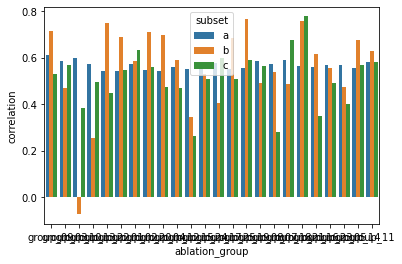

In [46]:
# concat all correlations and then plot

# if uninterrupted after ablation loop
# all_correlations_df = pd.concat(all_correlations, axis=0)
# sns.barplot(data=all_correlations_df, x='ablation_group', y='correlation', hue='subset')

# if interrupted during ablation loop read in prediction data
read_predictions = []

for group_name in all_groups:
    group_predict_path = os.path.join(ablation_predict_dir, group_name)
    load_predict = pd.read_csv(os.path.join(group_predict_path, group_name+'_predictions_combined.csv'))
    group_correlations = load_predict.drop(['question_id','annotator_id', 'group', 'mse'], axis=1).groupby(['ablation_group', 'subset']).corr()
    group_correlations_long = group_correlations.drop('labels', axis=1).reset_index().drop('level_2', axis=1).drop_duplicates(subset='subset').rename(columns={'predicted':'correlation'})
    read_predictions.append(group_correlations_long)
    
print("total number of groups:",len(read_predictions))

read_predictions_df = pd.concat(read_predictions, axis=0)
sns.barplot(data=read_predictions_df, x='ablation_group', y='correlation', hue='subset')

In [27]:
ablation_groups = read_predictions_df.ablation_group.unique()
ablation_groups.sort()

plot1 = ablation_groups[:6]
plot2 = ablation_groups[6:12]
plot3 = ablation_groups[12:18]
plot4 = ablation_groups[18:]

print(plot1)
print(plot2)
print(plot3)
print(plot4)

['group_01' 'group_02' 'group_03' 'group_04' 'group_05' 'group_07']
['group_08' 'group_09' 'group_10' 'group_11' 'group_12' 'group_13']
['group_14' 'group_15' 'group_16' 'group_17' 'group_18' 'group_19']
['group_20' 'group_21' 'group_22' 'group_23' 'group_24' 'group_25']


<ipython-input-38-8c7e5bef8908>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot1_df.sort_values(by=['ablation_group'], inplace=True)


<AxesSubplot:xlabel='ablation_group', ylabel='correlation'>

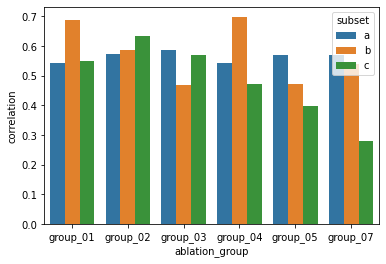

In [38]:
plot1_df = read_predictions_df[read_predictions_df.ablation_group.isin(plot1)]
plot1_df.sort_values(by=['ablation_group'], inplace=True)
sns.barplot(data=plot1_df, x='ablation_group', y='correlation', hue='subset')

<ipython-input-39-787be524d2ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot2_df.sort_values(by=['ablation_group'], inplace=True)


<AxesSubplot:xlabel='ablation_group', ylabel='correlation'>

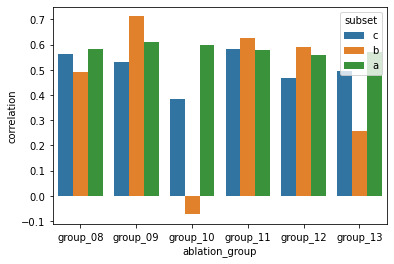

In [39]:
plot2_df = read_predictions_df[read_predictions_df.ablation_group.isin(plot2)]
plot2_df.sort_values(by=['ablation_group'], inplace=True)
sns.barplot(data=plot2_df, x='ablation_group', y='correlation', hue='subset')

<ipython-input-42-0897b3648052>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot3_df.sort_values(by=['ablation_group'], inplace=True)


<AxesSubplot:xlabel='ablation_group', ylabel='correlation'>

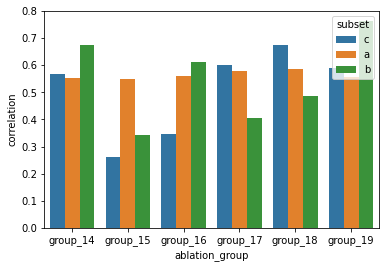

In [42]:
plot3_df = read_predictions_df[read_predictions_df.ablation_group.isin(plot3)]
plot3_df.sort_values(by=['ablation_group'], inplace=True)
sns.barplot(data=plot3_df, x='ablation_group', y='correlation', hue='subset')

<ipython-input-43-a8d99a412dfa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot4_df.sort_values(by=['ablation_group'], inplace=True)


<AxesSubplot:xlabel='ablation_group', ylabel='correlation'>

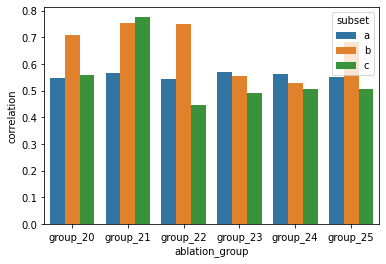

In [43]:
plot4_df = read_predictions_df[read_predictions_df.ablation_group.isin(plot4)]
plot4_df.sort_values(by=['ablation_group'], inplace=True)
sns.barplot(data=plot4_df, x='ablation_group', y='correlation', hue='subset')